In [1]:
import os 
os.chdir('../../../')
print("Current working directory is now: ", os.getcwd())

import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt 

from utils.load_settings import load_settings
from utils.fairness_functions import compute_calibration_discrete_score, compute_eq_odds_arnold_nvca
from utils.plotting_helpers import safe_save_plt
from utils.plot_fairness import plot_binary_calib_arnold_nvca, plot_eq_odds_arnold_nvca

%matplotlib inline
# load parameters
settings = load_settings()

Current working directory is now:  C:\Users\binha\Documents\Duke\Cynthia Research\interpretable_ml


In [2]:
# read in data 
broward_data = pd.read_csv("broward/data/broward_data.csv")
broward_arnold_compas = pd.read_csv("broward/data/broward_arnold.csv")

for decoder_name, decoder_dict in settings['decoders'].items():
    broward_arnold_compas = broward_arnold_compas.replace({decoder_name: decoder_dict})

broward_arnold_compas.rename(columns=settings['decoders']['label'], inplace=True)

broward_arnold_compas = broward_arnold_compas[['person_id', 'screening_date',
                                               'arnold_nvca', 
                                               'sex', 'race',
                                               'violent_two_year']]

# wide to long on sensitive attrs
broward_long = (pd.melt(broward_arnold_compas, id_vars =['person_id', 'screening_date'], value_vars=['sex', 'race'])
                         .rename({'variable': 'Attribute',
                                  'value': 'Attribute Value'},
                                   axis=1))
broward_long = broward_long.merge(broward_arnold_compas.drop(columns=['sex', 'race']),
                                                    on = ['person_id', 'screening_date'],
                                                    how = 'left')
broward_long.head()

,person_id,screening_date,Attribute,Attribute Value,arnold_nvca,violent_two_year
0,1001,2014-02-03,sex,male,Yes,0
1,101,2013-01-13,sex,male,No,1
2,101,2014-02-02,sex,male,Yes,0
3,1015,2014-01-22,sex,male,Yes,0
4,1016,2013-04-15,sex,male,Yes,1


# Arnold NVCA Visualizations

Since the Arnold NVCA score is binary, we generate bar charts rather than line graphs to display calibration, BPC, BNC. 

## Calibration is equivalent to conditional use accuracy equality

$P(Y = 1 | d(x) = 1 , \textit{gender = male}) 
    = P( Y = 1  | d(x) = 1, \textit{gender = female}), \text{(PPV)}$
$P(Y = 1 | d(x) = 0 , \textit{gender = male}) 
    = P( Y = 1  | d(x) = 0, \textit{gender = female}). \text{1 - (NPV)}$
    

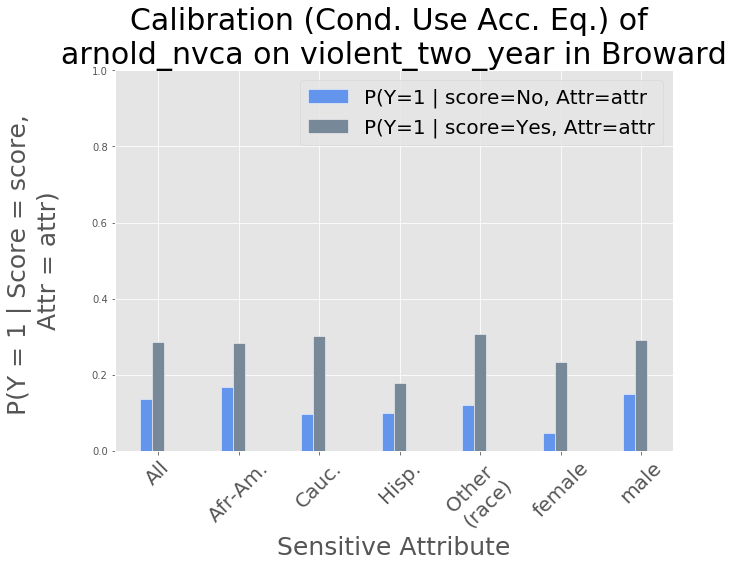

In [3]:
# arnold ncva 
calib, calib_grps = compute_calibration_discrete_score(long_df=broward_long, 
                                                        problem_name="violent_two_year", 
                                                        score_name="arnold_nvca")

plot_binary_calib_arnold_nvca(calib=calib, 
                              calib_grps=calib_grps,
                              region_name="Broward",
                              save_path='broward/logs/fairness_results/calibration_visualizations/arnold/arnold_nvca_calib.pdf')

## BPC/BNC is equivalent to equalized odds

$P(d(x) = 1 | Y = 1, \textit{gender = male}) 
    = P(d(x) = 1 | Y = 1 , \textit{gender = female}), \text{1 - (FNR)}$

$P(d(x) = 1 | Y = 0, \textit{gender = male}) 
    = P(d(x) = 1 | Y = 0 , \textit{gender = female}). \text{(FPR)}$    

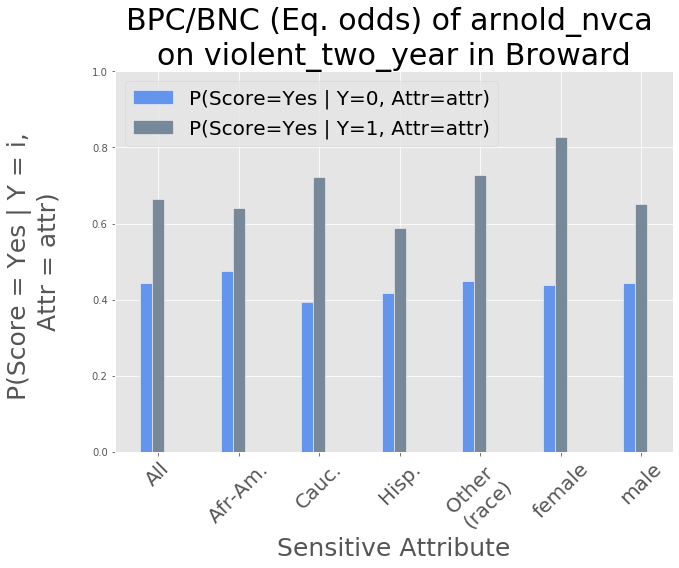

In [4]:
eq_odds, eq_odds_grps = compute_eq_odds_arnold_nvca(long_df=broward_long)

plot_eq_odds_arnold_nvca(eq_odds=eq_odds, 
                         eq_odds_grps=eq_odds_grps,
                         region_name="Broward",
                         save_path='broward/logs/fairness_results/equalized_odds_visualizations/arnold_nvca_eq_odds.pdf')